# Backflow

Paper title: Backflow Transformations via Neural Networks for Quantum Many-Body Wave Functions

Paper authors: Di Luo and Bryan K. Clark

[arxiv:1807.10770 (2018)](https://arxiv.org/abs/1807.10770)

[Phys. Rev. Lett. 122, 226401 (2019)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.122.226401)

In this example, we use neural network backflow (NNBF) to solve the ground state of 4x4 Hubbard model at 1/8 hole doping.

Estimated cost: 1 A100 x 20 min

## Define system and perform ED

The Hubbard Hamiltonian is

$$
H = -t \sum_{\left<ij\right>,\sigma} (c_{i\sigma}^\dagger c_{j\sigma} + h.c.)
+ U \sum_i n_{i\uparrow} n_{i\downarrow}
$$

In the 4x4 system with 1/8 doping, the ground state sector is defined by momentum $k=0$, B1 representation of $C_{4v}$ group, and spin inverse eigenvalue -1.

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]='false'

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import quantax as qtx
from quantax.symmetry import Trans2D, C4v, SpinInverse
import matplotlib.pyplot as plt
from IPython.display import clear_output
%config InlineBackend.figure_format = 'svg'

# 4x4 lattice with 1/8 hole doping, 7 spin-up and 7 spin-down fermions
lattice = qtx.sites.Square(
    4, particle_type=qtx.PARTICLE_TYPE.spinful_fermion, Nparticle=(7, 7)
)
N = lattice.N

H = qtx.operator.Hubbard(U=8)

# 
symm = Trans2D() + C4v("B1") + SpinInverse(-1)

E_gs = -11.86883556956402

# E_gs, wf_gs = H.diagonalize(symm)
# E_gs = E_gs[0]
# ground_state = qtx.state.DenseState(wf_gs, symm)
# print(E_gs)

## Slater-Jastrow determinant state (S0)

The Jastrow-Slater wave function can be expressed as

$$
\psi_\mathrm{S0}(n) = J(n) \times \det(n_\uparrow \star \phi_\uparrow) \times \det(n_\downarrow \star \phi_\downarrow),
$$

where $n \star \phi$ means the full orbital matrix is sliced according to the fermion occupation number, and $J(n)$ is the Jastrow factor given by

$$
J(n) = \frac{1}{2} \sum_{ij} v_{ij} n_i n_j.
$$

The variational parameters are $\phi_\uparrow$, $\phi_\downarrow$, and $v$. We start by training this simple wave function to obtain a good initial state.

In [54]:
from quantax.utils import fermion_idx


def _init_params():
    keys = qtx.get_subkeys(3)
    Nup, Ndn = lattice.Nparticle
    phi_up = jr.normal(keys[0], (N, Nup))
    phi_dn = jr.normal(keys[1], (N, Ndn))

    M = lattice.nstates
    v = jr.normal(keys[2], (M, M)) / M
    return phi_up, phi_dn, v


def _slater_forward(phi_up, phi_dn, n):
    idx = fermion_idx(n)
    Nup = lattice.Nparticle[0]
    idx_up = idx[:Nup]
    idx_dn = idx[Nup:] - N
    M_up = phi_up[idx_up]
    M_dn = phi_dn[idx_dn]
    return jnp.linalg.det(M_up) * jnp.linalg.det(M_dn)


class JastrowSlater(eqx.Module):
    phi_up: jax.Array
    phi_dn: jax.Array
    v: jax.Array

    def __init__(self):
        self.phi_up, self.phi_dn, self.v = _init_params()

    def __call__(self, n: jax.Array) -> jax.Array:
        jastrow = jnp.exp(0.5 * n @ self.v @ n)
        return jastrow * _slater_forward(self.phi_up, self.phi_dn, n)
    

model_s0 = JastrowSlater()
state_s0 = qtx.state.Variational(model_s0, max_parallel=8192*45)
sampler = qtx.sampler.ParticleHop(state_s0, 8192, sweep_steps=10 * N)
optimizer = qtx.optimizer.SR(state_s0, H)

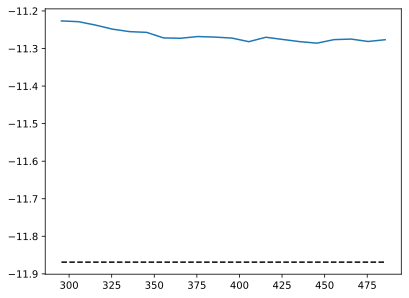

In [55]:
energy = qtx.utils.DataTracer()

for i in range(500):
    samples = sampler.sweep()
    step = optimizer.get_step(samples)
    state_s0.update(step * 0.02)
    energy.append(optimizer.energy)

    if i % 10 == 0:
        clear_output()
        energy.plot(start=-200, batch=10, baseline=E_gs)
        plt.show()

The relative error of Jastrow-Slater determinant state is around 5%, as presented by S0 percentage error in Fig.2.

In [56]:
E = energy[-20:].mean()
print("Relative error:", jnp.abs((E - E_gs) / E_gs))

Relative error: 0.04942455128562643


## Slater determinant NNBF (SN)

Now we start applying neural networks. It provides a correction to single-particle orbitals as

$$
\phi^b_\sigma(n) = \phi_\sigma + a(n),
$$

where $a(n)$ is given by neural networks. The full wave function is given by

$$
\psi_\mathrm{SN}(n) = J(n) \times \det(n_\uparrow \star \phi^b_\uparrow(n)) \times \det(n_\downarrow \star \phi^b_\downarrow(n)).
$$

In [108]:
class SlaterBackflow(eqx.Module):
    mlp_up: eqx.nn.MLP
    mlp_dn: eqx.nn.MLP
    phi_up: jax.Array
    phi_dn: jax.Array
    v: jax.Array

    def __init__(self, width: int):
        self.phi_up, self.phi_dn, self.v = _init_params()

        keys = qtx.get_subkeys(2)
        self.mlp_up = eqx.nn.MLP(
            in_size=lattice.nstates,
            out_size=self.phi_up.size,
            width_size=width,
            depth=1,
            use_final_bias=False, # final bias is phi
            key=keys[0],
        )

        self.mlp_dn = eqx.nn.MLP(
            in_size=lattice.nstates,
            out_size=self.phi_up.size,
            width_size=width,
            depth=1,
            use_final_bias=False, # final bias is phi
            key=keys[1],
        )

    def __call__(self, n: jax.Array) -> jax.Array:
        jastrow = jnp.exp(0.5 * n @ self.v @ n)
        phi_up = self.phi_up + self.mlp_up(n).reshape(self.phi_up.shape)
        phi_dn = self.phi_dn + self.mlp_dn(n).reshape(self.phi_dn.shape)
        return jastrow * _slater_forward(phi_up, phi_dn, n)


model_sn = SlaterBackflow(width=256)

# Initialize the backflow model with the optimized S0 parameters
model0 = state_s0.model
model_sn = eqx.tree_at(lambda model: model.phi_up, model_sn, model0.phi_up)
model_sn = eqx.tree_at(lambda model: model.phi_dn, model_sn, model0.phi_dn)
model_sn = eqx.tree_at(lambda model: model.v, model_sn, model0.v)

state_sn = qtx.state.Variational(model_sn, max_parallel=8192*45)
sampler = qtx.sampler.ParticleHop(state_sn, 8192, sweep_steps=10 * N)
optimizer = qtx.optimizer.SR(state_sn, H)

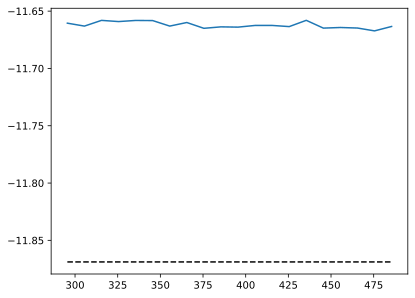

In [109]:
energy = qtx.utils.DataTracer()

for i in range(500):
    samples = sampler.sweep()
    step = optimizer.get_step(samples)
    state_sn.update(step * 0.05)
    energy.append(optimizer.energy)

    if i % 10 == 0:
        clear_output()
        energy.plot(start=-200, batch=10, baseline=E_gs)
        plt.show()

The relative error of Jastrow-Slater backflow state is around 1.6%, as presented by SN percentage error in Fig.2.

In [110]:
E = energy[-20:].mean()
print("Relative error:", jnp.abs((E - E_gs) / E_gs))

Relative error: 0.017430909912168422


## Plot with SN result

Then we can measure the charge and spin density as presented in Fig.3.

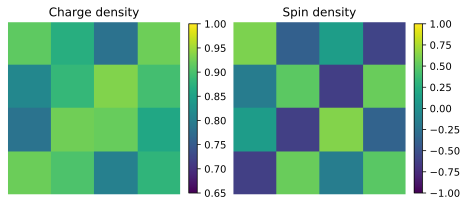

In [119]:
from quantax.operator import number_u, number_d

def charge(i):
    return number_u(i) + number_d(i)

def spin(i):
    return number_u(i) - number_d(i)

samples = sampler.sweep()

charge_op = [charge(i) for i in range(N)]
spin_op = [spin(i) for i in range(N)]

charge_density = [op.expectation(state_sn, samples) for op in charge_op]
charge_density = np.asarray(charge_density).reshape(lattice.shape[1:])
spin_density = [op.expectation(state_sn, samples) for op in spin_op]
spin_density = np.asarray(spin_density).reshape(lattice.shape[1:])

fig, axes = plt.subplots(1, 2, constrained_layout=True)

im = axes[0].imshow(charge_density, cmap='viridis', vmin=0.65, vmax=1)
axes[0].axis('off')
axes[0].set_title("Charge density")
fig.colorbar(im, ax=axes[0], shrink=0.5)

im = axes[1].imshow(spin_density, cmap='viridis', vmin=-1, vmax=1)
axes[1].axis('off')
axes[1].set_title("Spin density")
fig.colorbar(im, ax=axes[1], shrink=0.5)

plt.show()

The backflow parameters in Fig.4 and Fig.5 are shown below.

Occupation number:
 [[ 1  1 -1 -1 -1 -1 -1  1 -1 -1  1 -1  1  1 -1  1]
 [-1 -1  1 -1  1  1  1 -1 -1  1 -1  1  1 -1 -1 -1]]


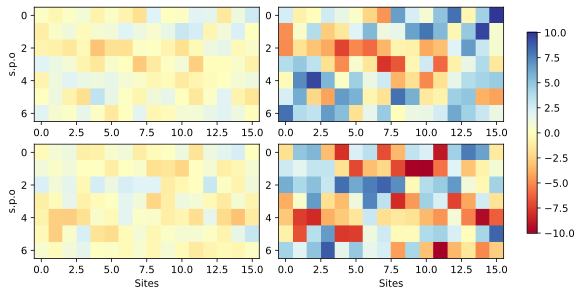

In [120]:
n = samples.spins[0]
print("Occupation number:\n", n.reshape(2, -1))

phi0u = state_sn.model.phi_up
phi0d = state_sn.model.phi_dn
phinu = phi0u + state_sn.model.mlp_up(n).reshape(phi0u.shape)
phind = phi0d + state_sn.model.mlp_dn(n).reshape(phi0d.shape)

fig, axes = plt.subplots(2, 2, figsize=(8, 4), constrained_layout=True)

phi_stack = jnp.stack([phi0u, phi0d, phinu, phind])
vmax = jnp.max(jnp.abs(phi_stack))

axes[0, 0].imshow(phi0u.T, cmap="RdYlBu", vmin=-vmax, vmax=vmax, aspect="auto")
axes[0, 0].set_ylabel("s.p.o")

axes[1, 0].imshow(phi0d.T, cmap="RdYlBu", vmin=-vmax, vmax=vmax, aspect="auto")
axes[1, 0].set_xlabel("Sites")
axes[1, 0].set_ylabel("s.p.o")

axes[0, 1].imshow(phinu.T, cmap="RdYlBu", vmin=-vmax, vmax=vmax, aspect="auto")

im = axes[1, 1].imshow(phind.T, cmap="RdYlBu", vmin=-vmax, vmax=vmax, aspect="auto")
axes[1, 1].set_xlabel("Sites")

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)

plt.show()

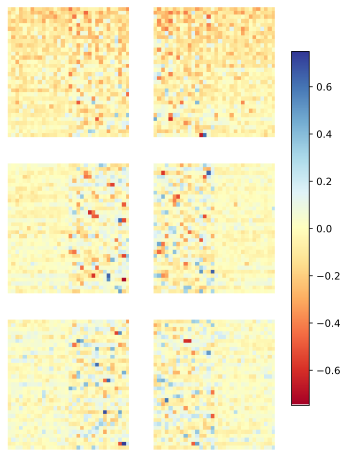

In [121]:
Wup = state_sn.model.mlp_up.layers[0].weight
Wdn = state_sn.model.mlp_dn.layers[0].weight
vmax_up = jnp.max(jnp.abs(Wup))
vmax_dn = jnp.max(jnp.abs(Wdn))
vmax = max(vmax_up, vmax_dn)

bup = state_sn.model.mlp_up.layers[0].bias
bdn = state_sn.model.mlp_dn.layers[0].bias
idx_up = jnp.argsort(bup)[::-1]
idx_dn = jnp.argsort(bdn)[::-1]

fig, axes = plt.subplots(3, 2, figsize=(6, 8))

axes[0, 0].imshow(
    Wup[idx_up[0:32]], cmap="RdYlBu", vmin=-vmax, vmax=vmax, aspect="auto"
)
axes[0, 0].axis("off")
axes[1, 0].imshow(
    Wup[idx_up[95:128]], cmap="RdYlBu", vmin=-vmax, vmax=vmax, aspect="auto"
)
axes[1, 0].axis("off")
axes[2, 0].imshow(
    Wup[idx_up[223:256]], cmap="RdYlBu", vmin=-vmax, vmax=vmax, aspect="auto"
)
axes[2, 0].axis("off")

axes[0, 1].imshow(
    Wdn[idx_dn[0:32]], cmap="RdYlBu", vmin=-vmax, vmax=vmax, aspect="auto"
)
axes[0, 1].axis("off")
axes[1, 1].imshow(
    Wdn[idx_dn[95:128]], cmap="RdYlBu", vmin=-vmax, vmax=vmax, aspect="auto"
)
axes[1, 1].axis("off")
im = axes[2, 1].imshow(
    Wdn[idx_dn[223:256]], cmap="RdYlBu", vmin=-vmax, vmax=vmax, aspect="auto"
)
axes[2, 1].axis("off")

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)

plt.show()

Another wave function utilized in the paper is pairing NNBF (PN), which is left for readers to try.